In [40]:
# load_data.py

import pandas as pd
from pymongo import MongoClient, DESCENDING
from datetime import date

# 配置数据库连接信息
MONGO_CONNECTION_STRING = "mongodb://localhost:27017/"
DB_NAME = "barra_financial_data"

def load_collection_to_df(db, collection_name: str, query: dict, projection: dict) -> pd.DataFrame:
    """加载经过筛选和投影的集合数据。"""
    print(f"正在从 '{collection_name}' 加载数据...")
    collection = db[collection_name]
    cursor = collection.find(query, projection)
    df = pd.DataFrame(list(cursor))
    print(f"-> 成功加载 {len(df):,} 行数据。")
    return df

def robust_merge_asof(left_df, right_df, left_on, right_on, by):
    """执行稳健的合并操作，确保在合并时考虑到时间序列的顺序。"""
    print(f"--- Performing robust merge_asof on '{by}' ---")
    left_df = left_df.reset_index(drop=True).sort_values(by=[by, left_on])
    right_df = right_df.reset_index(drop=True).sort_values(by=[by, right_on])
    all_keys = left_df[by].unique()
    merged_chunks = []
    for key in all_keys:
        left_chunk = left_df[left_df[by] == key]
        right_chunk = right_df[right_df[by] == key]
        merged_chunk = pd.merge_asof(
            left=left_chunk, right=right_chunk, left_on=left_on,
            right_on=right_on, by=by, direction='backward'
        )
        merged_chunks.append(merged_chunk)
    print("Robust merge successful.")
    return pd.concat(merged_chunks, ignore_index=True)


# --- 主函数，用于被外部调用 ---
def load_and_prepare_data():
    """
    连接数据库，加载、处理并合并所有需要的数据。
    返回:
        - stock_price_with_financials_df: 包含所有股票日线和财报数据的大表
        - index_prices_df: 指数行情数据
        - sw_industry_data: 申万行业分类数据
    """
    client = MongoClient(MONGO_CONNECTION_STRING)
    db = client[DB_NAME]
    print("成功连接到 MongoDB。")

    # --- 数据加载部分 ---
    start_date_str = "20200101"
    start_date_financial_str = "20190101"
    end_date_str = date.today().strftime('%Y%m%d')
    index_code = "000300.SH"
    
    # ... (这里省略了所有find和load_collection_to_df的调用代码，它们保持原样) ...
    # ... (假设 constituent_list, daily_prices_df, cashflow_df, 等都已成功加载) ...
    # 选择想要查询的股票池，如：沪深300、上证50等

    # 首先连接到指数成分股集合，获取成分股列表
    index_components_collection_name = "index_components"
    index_code = "000300.SH"

    # 1. 查找最新的交易日期
    print(f"\n正在为指数 '{index_code}' 查找最新交易日期...")
    collection = db[index_components_collection_name]

    # 使用 find_one() 配合 sort 可以高效地找到一个文档
    latest_entry = collection.find_one(
        {"index_code": index_code},      # 筛选条件
        sort=[("trade_date", DESCENDING)]       # 按 trade_date 降序排列
    )

    # 检查是否找到了数据
    if latest_entry:
        latest_trade_date = latest_entry['trade_date']
        print(f"-> 找到最新交易日期: {latest_trade_date}")

        # 2. 使用找到的最新日期来查询所有成分股
        index_info_query = {
            "index_code": index_code,
            "trade_date": latest_trade_date  # 使用动态获取的日期
        }
        index_info_projection = {"con_code": 1, "_id": 0}

        # 调用你的辅助函数加载数据
        index_constituents_df = load_collection_to_df(
            db,
            collection_name=index_components_collection_name,
            query=index_info_query,
            projection=index_info_projection
        )

    
        constituent_list = index_constituents_df['con_code'].tolist()
        print(f"\n共获取 {len(constituent_list)} 只成分股。")

    else:
        print(f"!! 未能在集合 '{index_components_collection_name}' 中找到指数 '{index_code}' 的任何记录。")

    # 根据成分股列表，加载所需的股票数据
    # 日线行情：close, total_mv, pb, turnover_rate, pe_ttm, circ_mv

    daily_prices_query = {
        "ts_code": {"$in": constituent_list},
        "trade_date": {"$gte": start_date_str, "$lte": end_date_str}
    }

    daily_prices_projection = {
        "ts_code": 1,
        "trade_date": 1,
        "close": 1,
        "total_mv": 1,
        "circ_mv": 1,
        "pb": 1,
        "turnover_rate": 1,
        "pe_ttm": 1,
        "_id": 0
    }

    daily_prices_df = load_collection_to_df(
        db,
        collection_name="daily_prices",
        query=daily_prices_query,
        projection=daily_prices_projection
    )


    # 现金流量：n_cashflow_act 
    cashflow_query = {
        "ts_code": {"$in": constituent_list},
        "end_date": {"$gte": start_date_financial_str, "$lte": end_date_str}
    }

    cashflow_projection = {
        "ts_code": 1,
        "f_ann_date": 1,
        "end_date": 1,
        "n_cashflow_act": 1,
        "_id": 0
    }

    cashflow_df = load_collection_to_df(
        db,
        collection_name="cashflow",
        query=cashflow_query,
        projection=cashflow_projection
    )


    # 财务指标： 'q_profit_yoy', 'q_sales_yoy', debt_to_assets
    financial_indicators_query = {
        "ts_code": {"$in": constituent_list},
        "end_date": {"$gte": start_date_financial_str, "$lte": end_date_str}
    }

    financial_indicators_projection = {
        "ts_code": 1,
        "ann_date": 1, 
        "end_date": 1,
        "q_profit_yoy": 1,
        "q_sales_yoy": 1,
        "debt_to_assets": 1,
        "_id": 0
    }

    financial_indicators_df = load_collection_to_df(
        db,
        collection_name="financial_indicators",
        query=financial_indicators_query,
        projection=financial_indicators_projection
    )




    # 资产负债表： total_ncl, total_hldr_eqy_inc_min_int, 
    balance_sheet_query = {
        "ts_code": {"$in": constituent_list},
        "end_date": {"$gte": start_date_financial_str, "$lte": end_date_str}
    }
    balance_sheet_projection = {
        "ts_code": 1,
        "f_ann_date": 1,
        "end_date": 1,
        "total_ncl": 1,
        "total_hldr_eqy_inc_min_int": 1,
        "_id": 0
    }
    balance_sheet_df = load_collection_to_df(
        db,
        collection_name="balancesheet",
        query=balance_sheet_query,
        projection=balance_sheet_projection 
    )



    # 指数数据: close

    index_prices_query = {
        "ts_code": index_code,
        "trade_date": {"$gte": start_date_str, "$lte": end_date_str}            
}   

    index_prices_projection = {
        "ts_code": 1,
        "trade_date": 1,
        "close": 1,
        "_id": 0
    }

    index_prices_df = load_collection_to_df(
        db,
        collection_name="index_daily_prices",
        query=index_prices_query,
        projection=index_prices_projection
    )

    sw_industry_projection = {
        "ts_code": 1,
        "l1_code": 1,
        "l1_name": 1,
        "in_date": 1,
        "out_date": 1,
        "is_new": 1,
        "_id": 0
    }

    sw_industry_df = load_collection_to_df(db, 'sw_industries', {}, sw_industry_projection)
    
    
    # --- 数据去重与日期处理 ---
    # 获取数据完毕后，将数据合并，涉及到时间格式

    # 首先对财务数据去重
    cashflow_processed_df = cashflow_df.copy()
    cashflow_processed_df['f_ann_date'] = pd.to_datetime(cashflow_processed_df['f_ann_date'], format='%Y%m%d')
    cashflow_processed_df['end_date'] = pd.to_datetime(cashflow_processed_df['end_date'], format='%Y%m%d')

    # 先排序（按 f_ann_date 降序保留最新），然后去重保留第一条
    cashflow_processed_df = cashflow_processed_df.sort_values(
        ['ts_code', 'end_date', 'f_ann_date'],
        ascending=[True, True, False]  # f_ann_date 降序，最新在前
    ).drop_duplicates(subset=['ts_code', 'end_date'], keep='first')

    # 这次按照 end_date 降序，保留报告期最新的
    cashflow_processed_df= cashflow_processed_df.sort_values(
        ['ts_code', 'f_ann_date', 'end_date'],
        ascending=[True, True, False]  # end_date 降序，最新在前
    ).drop_duplicates(subset=['ts_code', 'f_ann_date'], keep='first')

    print('现金流数据去重处理与日期处理完毕')

    balance_sheet_processed_df = balance_sheet_df.copy()

    balance_sheet_processed_df['f_ann_date'] = pd.to_datetime(balance_sheet_processed_df['f_ann_date'], format='%Y%m%d')
    balance_sheet_processed_df['end_date'] = pd.to_datetime(balance_sheet_processed_df['end_date'], format='%Y%m%d')

    # 先排序（按 f_ann_date 降序保留最新），然后去重保留第一条
    balance_sheet_processed_df = balance_sheet_processed_df.sort_values(
        ['ts_code', 'end_date', 'f_ann_date'],
        ascending=[True, True, False]  # f_ann_date 降序，最新在前
    ).drop_duplicates(subset=['ts_code', 'end_date'], keep='first')

    balance_sheet_processed_df= balance_sheet_processed_df.sort_values(
        ['ts_code', 'f_ann_date', 'end_date'],
        ascending=[True, True, False]  # end_date 降序，最新在前
    ).drop_duplicates(subset=['ts_code', 'f_ann_date'], keep='first')

    print('资产负债表数据去重处理与日期处理完毕')

    financial_indicators_processed_df = financial_indicators_df.copy()

    financial_indicators_processed_df['ann_date'] = pd.to_datetime(financial_indicators_processed_df['ann_date'], format='%Y%m%d')
    financial_indicators_processed_df['end_date'] = pd.to_datetime(financial_indicators_processed_df['end_date'], format='%Y%m%d')

    financial_indicators_processed_df = financial_indicators_processed_df.sort_values(
        ['ts_code', 'ann_date', 'end_date'],
        ascending=[True, True, False]  # end_date 降序，最新在前
    ).drop_duplicates(subset=['ts_code', 'ann_date'], keep='first')

    print('财务指标数据日期处理完毕')
    

    daily_prices_processed_df = daily_prices_df.copy()
    daily_prices_processed_df['trade_date'] = pd.to_datetime(daily_prices_processed_df['trade_date'], format='%Y%m%d')

    print('日线行情数据日期处理完毕')

    index_prices_processed_df = index_prices_df.copy()
    index_prices_processed_df['trade_date'] = pd.to_datetime(index_prices_processed_df['trade_date'], format='%Y%m%d')
    print('指数行情数据日期处理完毕')


    # --- 数据合并 (与您原代码基本相同) ---
    '''
    对于每一个 ts_code 和 trade_date，
    寻找其所有财务报告中，f_ann_date（公告日）小于等于 trade_date 的所有报告，
    然后在这些报告中，选择 end_date（报告期）最晚 的那一条。
    '''
    merged_df_1 = robust_merge_asof(
        daily_prices_processed_df,
        balance_sheet_processed_df,
        left_on='trade_date',
        right_on='f_ann_date',
        by='ts_code'
    )

    merged_df_1.rename(columns={
        'f_ann_date': 'balance_sheet_f_ann_date',
    }, inplace=True)


    merged_df_2 = robust_merge_asof(
        merged_df_1,
        financial_indicators_processed_df,
        left_on='trade_date',
        right_on='ann_date',
        by='ts_code'
    )
    merged_df_2.rename(columns={
        'ann_date': 'financial_indicators_ann_date',
    }, inplace=True)

    final_merged_df = robust_merge_asof(
        merged_df_2,
        cashflow_processed_df,
        left_on='trade_date',
        right_on='f_ann_date',
        by='ts_code'
    )
    final_merged_df.rename(columns={
        'f_ann_date': 'cashflow_f_ann_date',
    }, inplace=True)    

    stock_price_with_financials_df = final_merged_df.copy()
    columns_to_drop = ['end_date_y','end_date_x'] 

    stock_price_with_financials_df = stock_price_with_financials_df.drop(columns=columns_to_drop)
    

    
    print("数据加载和预处理全部完成。")
    client.close()
    
    # 返回主流程所需的所有DataFrames
    return stock_price_with_financials_df, index_prices_processed_df, sw_industry_df

stk_df, idx_df, sw_df = load_and_prepare_data()
print("\n--- Stock Data Info ---")
stk_df.info()
    
print("\n--- Index Data Info ---")
idx_df.info()

print("\n--- SW Industry Data Info ---")
sw_df.info()
    

成功连接到 MongoDB。

正在为指数 '000300.SH' 查找最新交易日期...
-> 找到最新交易日期: 20251009
正在从 'index_components' 加载数据...
-> 成功加载 300 行数据。

共获取 300 只成分股。
正在从 'daily_prices' 加载数据...
-> 成功加载 405,461 行数据。
正在从 'cashflow' 加载数据...
-> 成功加载 11,142 行数据。
正在从 'financial_indicators' 加载数据...
-> 成功加载 7,686 行数据。
正在从 'balancesheet' 加载数据...
-> 成功加载 10,389 行数据。
正在从 'index_daily_prices' 加载数据...
-> 成功加载 1,405 行数据。
正在从 'sw_industries' 加载数据...
-> 成功加载 5,724 行数据。
现金流数据去重处理与日期处理完毕
资产负债表数据去重处理与日期处理完毕
财务指标数据日期处理完毕
日线行情数据日期处理完毕
指数行情数据日期处理完毕
--- Performing robust merge_asof on 'ts_code' ---
Robust merge successful.
--- Performing robust merge_asof on 'ts_code' ---
Robust merge successful.
--- Performing robust merge_asof on 'ts_code' ---
Robust merge successful.
数据加载和预处理全部完成。

--- Stock Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405461 entries, 0 to 405460
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----  

In [41]:
stk_df = stk_df.sort_values(by=['ts_code', 'trade_date']).reset_index(drop=True)

# 组内向前填充，用它前面最近的一个非缺失值来填充当前的缺失值
fill_cols = [
    'pe_ttm', 'pb', 'total_ncl', 'total_hldr_eqy_inc_min_int',
    'debt_to_assets', 'q_sales_yoy', 'q_profit_yoy', 'n_cashflow_act',
    # 日期列也 ffill，便于追踪数据时效
    'balance_sheet_f_ann_date', 'financial_indicators_ann_date',
    'cashflow_f_ann_date', 'end_date'
]

# 3. 执行分组 ffill
stk_df[fill_cols] = stk_df.groupby('ts_code')[fill_cols].ffill()

In [42]:
stk_df

,ts_code,trade_date,close,turnover_rate,pe_ttm,pb,total_mv,circ_mv,balance_sheet_f_ann_date,total_ncl,total_hldr_eqy_inc_min_int,financial_indicators_ann_date,debt_to_assets,q_sales_yoy,q_profit_yoy,cashflow_f_ann_date,end_date,n_cashflow_act
0,000001.SZ,2020-01-02,16.87,0.7885,11.6992,1.2210,3.273778e+07,3.273750e+07,2019-10-22,NaN,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
1,000001.SZ,2020-01-03,17.18,0.5752,11.9142,1.2434,3.333937e+07,3.333908e+07,2019-10-22,NaN,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
2,000001.SZ,2020-01-06,17.07,0.4442,11.8379,1.2355,3.312590e+07,3.312562e+07,2019-10-22,NaN,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
3,000001.SZ,2020-01-07,17.15,0.3755,11.8933,1.2413,3.328115e+07,3.328087e+07,2019-10-22,NaN,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
4,000001.SZ,2020-01-08,16.66,0.4369,11.5535,1.2058,3.233026e+07,3.232998e+07,2019-10-22,NaN,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405456,688981.SH,2025-10-16,127.30,3.0622,233.9425,6.7427,1.018409e+08,2.545443e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
405457,688981.SH,2025-10-17,121.98,4.1035,224.1658,6.4609,9.758487e+07,2.439066e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
405458,688981.SH,2025-10-20,122.63,2.8568,225.3603,6.4954,9.810487e+07,2.452064e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
405459,688981.SH,2025-10-21,127.19,3.9216,233.7403,6.7369,1.017529e+08,2.543244e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09


In [43]:
# 用当天的横截面中位数（Median）或均值（Mean） 来填充剩余的 NaN。这相当于假设这只股票在这一天这个因子上表现“中性”，不偏离市场。
for col in fill_cols:
    # 确保列是数值类型
    if pd.api.types.is_numeric_dtype(stk_df[col]):
        # 按 'trade_date' 分组，计算中位数，然后用 transform + fillna 填充
        stk_df[col] = stk_df.groupby('trade_date')[col].transform(lambda x: x.fillna(x.median()))

# 5. 最后的清理
# 如果在某一天，所有股票的某个值都是 NaN（比如数据刚开始的几天），
# 那么中位数也是 NaN。这时可以用 0 或全局 ffill/bfill 来彻底清理。
stk_df[fill_cols] = stk_df[fill_cols].fillna(0) # 简单起见，用 0 填充
# 或者 df = df.dropna() # 也可以选择删除这些无法填充的行

In [44]:
stk_df.isnull().sum()

ts_code                          0
trade_date                       0
close                            0
turnover_rate                    0
pe_ttm                           0
pb                               0
total_mv                         0
circ_mv                          0
balance_sheet_f_ann_date         0
total_ncl                        0
total_hldr_eqy_inc_min_int       0
financial_indicators_ann_date    0
debt_to_assets                   0
q_sales_yoy                      0
q_profit_yoy                     0
cashflow_f_ann_date              0
end_date                         0
n_cashflow_act                   0
dtype: int64

<Axes: title={'center': 'PE TTM over Time for 000001.SZ'}, xlabel='trade_date'>

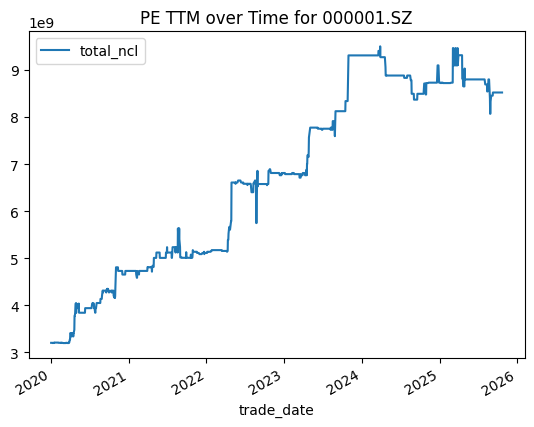

In [22]:
stk_df[stk_df['ts_code']=='000001.SZ'].plot(x='trade_date', y='total_ncl', title='PE TTM over Time for 000001.SZ')

In [45]:
stk_df.isnull().sum()

ts_code                          0
trade_date                       0
close                            0
turnover_rate                    0
pe_ttm                           0
pb                               0
total_mv                         0
circ_mv                          0
balance_sheet_f_ann_date         0
total_ncl                        0
total_hldr_eqy_inc_min_int       0
financial_indicators_ann_date    0
debt_to_assets                   0
q_sales_yoy                      0
q_profit_yoy                     0
cashflow_f_ann_date              0
end_date                         0
n_cashflow_act                   0
dtype: int64

In [51]:
stk_df['end_date'] = pd.to_datetime(stk_df['end_date'])
stk_df['balance_sheet_f_ann_date'] = pd.to_datetime(stk_df['balance_sheet_f_ann_date'])
stk_df['financial_indicators_ann_date'] = pd.to_datetime(stk_df['financial_indicators_ann_date'])
stk_df['cashflow_f_ann_date'] = pd.to_datetime(stk_df['cashflow_f_ann_date'])

In [52]:
stk_df

,ts_code,trade_date,close,turnover_rate,pe_ttm,pb,total_mv,circ_mv,balance_sheet_f_ann_date,total_ncl,total_hldr_eqy_inc_min_int,financial_indicators_ann_date,debt_to_assets,q_sales_yoy,q_profit_yoy,cashflow_f_ann_date,end_date,n_cashflow_act
0,000001.SZ,2020-01-02,16.87,0.7885,11.6992,1.2210,3.273778e+07,3.273750e+07,2019-10-22,3.203857e+09,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
1,000001.SZ,2020-01-03,17.18,0.5752,11.9142,1.2434,3.333937e+07,3.333908e+07,2019-10-22,3.203857e+09,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
2,000001.SZ,2020-01-06,17.07,0.4442,11.8379,1.2355,3.312590e+07,3.312562e+07,2019-10-22,3.203857e+09,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
3,000001.SZ,2020-01-07,17.15,0.3755,11.8933,1.2413,3.328115e+07,3.328087e+07,2019-10-22,3.203857e+09,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
4,000001.SZ,2020-01-08,16.66,0.4369,11.5535,1.2058,3.233026e+07,3.232998e+07,2019-10-22,3.203857e+09,2.880730e+11,2019-10-22,92.2304,19.3930,16.0079,2019-10-22,2019-09-30,8.448000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405456,688981.SH,2025-10-16,127.30,3.0622,233.9425,6.7427,1.018409e+08,2.545443e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
405457,688981.SH,2025-10-17,121.98,4.1035,224.1658,6.4609,9.758487e+07,2.439066e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
405458,688981.SH,2025-10-20,122.63,2.8568,225.3603,6.4954,9.810487e+07,2.452064e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
405459,688981.SH,2025-10-21,127.19,3.9216,233.7403,6.7369,1.017529e+08,2.543244e+07,2025-08-29,6.755544e+10,2.345195e+11,2025-08-29,33.7830,17.3407,-12.1687,2025-08-29,2025-06-30,5.897793e+09
